In [1]:
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
import matplotlib.patches as patches
pplt.rc.reso='hi'
warnings.filterwarnings('ignore')

In [2]:
REGIONS   = {
    'Eastern Arabian Sea':{'latmin':9.,'latmax':18.,'lonmin':67.,'lonmax':72.5}, 
    'Central India':{'latmin':18.,'latmax':24.,'lonmin':76.,'lonmax':83.},
    'Northern Bay of Bengal':{'latmin':18.,'latmax':21.5,'lonmin':87.5,'lonmax':90.},
    'Central Bay of Bengal':{'latmin':8.5,'latmax':15.,'lonmin':86.,'lonmax':90.}} 
FILEDIR   = '/ocean/projects/atm200007p/sferrett/Repos/monsoon-pr/data/raw'
SAVEDIR   = '/ocean/projects/atm200007p/sferrett/Repos/monsoon-pr/figs'
LATRANGE  = (5.,25.)
LONRANGE  = (60.,90.)
STDTHRESH = 75.

In [3]:
def open_dataset(filename,filedir=FILEDIR):
    filepath = f'{filedir}/{filename}'
    ds = xr.open_dataset(filepath)
    return ds

data = open_dataset('IMERG_precipitation_flux.nc')

In [36]:
def make_patch(lonmin,lonmax,latmin,latmax):
    patchkwargs = dict(edgecolor='k',facecolor='none',linewidth=1)
    return patches.Rectangle((lonmin,latmin),lonmax-lonmin,latmax-latmin,**patchkwargs)

patchkwargs = dict(edgecolor='k',facecolor='none',linewidth=1)
prkwargs    = dict(cmap='ColdHot_r',cmap_kw={'left':0.5},vmin=0,vmax=18,levels=19,extend='max')
maskkwargs  = dict(levels=[0,np.max(pr)],hatches=['/////'],alpha=0,colors='none')
diffkwargs  = dict(cmap='ColdHot_r',vmin=-9,vmax=9,levels=22,extend='both')
divkwargs   = dict(levels=[0],color='k',linewidth=0.5,linestyle='--')

NameError: name 'mask' is not defined

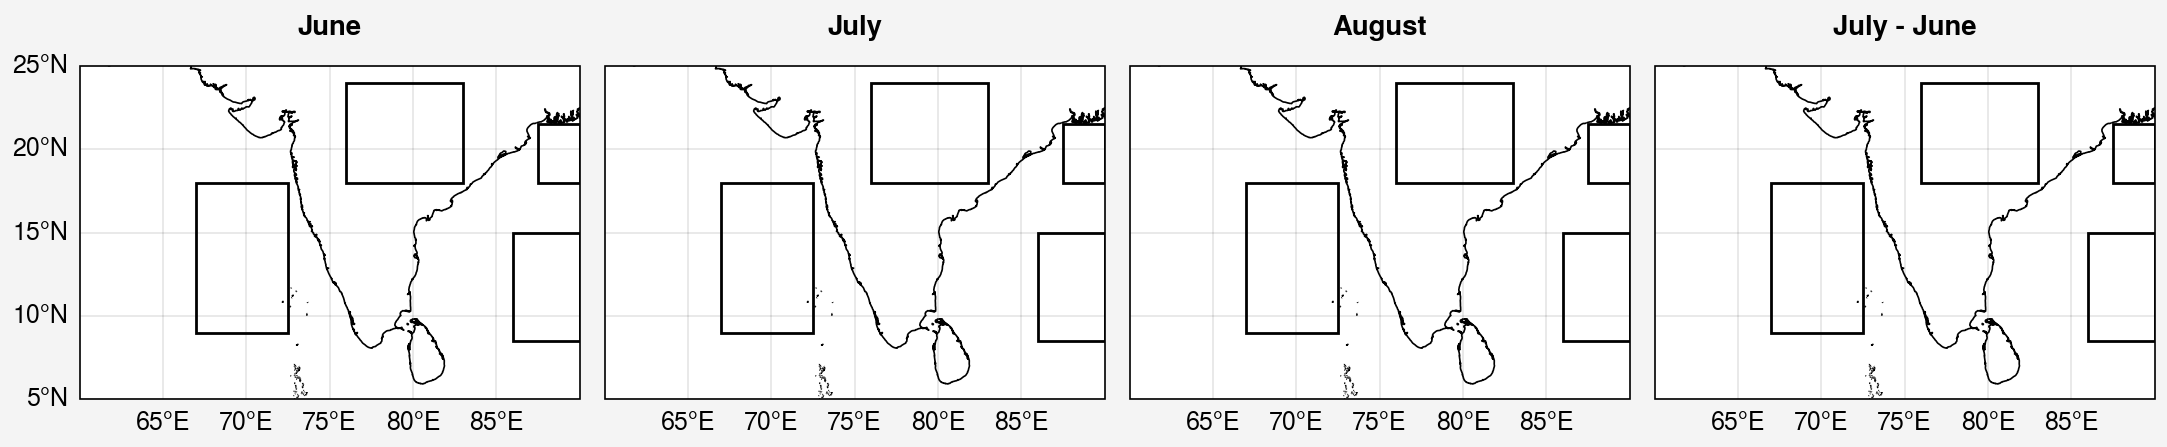

In [55]:
pr  = data.pr.groupby('time.month').mean(dim='time')
std = data.pr.groupby('time.month').std(dim='time')
prdiff  = pr.isel(month=1)-pr.isel(month=0)
stdmask = std > np.percentile(std,STDTHRESH)

fig,axs = pplt.subplots(nrows=1,ncols=4,proj='cyl')
axs.format(collabels=['June','July','August','July - June'],coast=True,
           latlim=LATRANGE,latlines=5,lonlim=LONRANGE,lonlines=5,lonlabels=True)
axs[0].format(latlabels=True)

for region in REGIONS.values():
    for ax in axs:
        ax.add_patch(make_patch(region['lonmin'],region['lonmax'],region['latmin'],region['latmax']))

for i,ax in enumerate(axs[:3]):
    monthlypr   = pr.isel(month=i)
    monthlymask = np.ma.masked_where(~mask.isel(month=i),monthlypr)
    m = ax.contourf(monthlypr,**prkwargs)
    ax.contourf(monthlymask,**maskkwargs)
axs[-1].colorbar(m,loc='r',ticks=3,label='Precipitation (mm/day)')
    
m = ax.contourf(prdiff,**diffkwargs)
ax.contour(prdiff,**divkwargs)
ax.colorbar(m,loc='r',ticks=3,label='$\Delta$Precipitation (mm/day)')
    
# plot_diff(axs[3],prdiff,diffkwargs,divkwargs)
# pplt.show()
# fig.save(f'{SAVEDIR}/fig_1.png',dpi=300)

In [52]:
# from scipy.stats import norm,t

# Get monthly-mean rainfall for each year (2000-2020) for each month
junpr = data.pr.sel(time=data['time.month']==6).groupby('time.year').mean(dim='time')
julpr = data.pr.sel(time=data['time.month']==7).groupby('time.year').mean(dim='time')
augpr = data.pr.sel(time=data['time.month']==8).groupby('time.year').mean(dim='time')

# Calculate the difference between 2 months for each year
jjdiff = julpr-junpr
jadiff = augpr-julpr

# Calculate the mean and standard deviation of the differences
meanjjdiff = jjdiff.mean(dim='year')
stdjjdiff  = jjdiff.std(dim='year',ddof=1)
meanjadiff = jadiff.mean(dim='year')
stdjadiff  = jadiff.std(dim='year',ddof=1)

# Number of years
nyears = jjdiff.sizes['year']

# Calculate the t-statistic
jjtstat = meanjjdiff/(stdjjdiff/np.sqrt(nyears))
jatstat = meanjadiff/(stdjadiff/np.sqrt(nyears))

# Calculate the two-tailed p-values from the t-statistics and put into an Xarray dataset
jjpvalues = 2*(1-t.cdf(np.abs(jjtstat),df=nyears-1))
jjpvalues = xr.DataArray(jjpvalues,coords=[junpr.lat,junpr.lon],dims=['lat','lon'])
japvalues = 2*(1-t.cdf(np.abs(jatstat),df=nyears-1))
japvalues = xr.DataArray(japvalues,coords=[junpr.lat,junpr.lon],dims=['lat','lon'])

# Determine significance based on a chosen alpha level (e.g., 0.05 for a 95% confidence level)
alpha = 0.05
jjsignificant = jjpvalues<alpha
jasignificant = japvalues<alpha

# Create dataset to store the results
# results = xr.Dataset({
#     'tstat':(['lat','lon'],tstat.data),
#     'pvalues':(['lat','lon'],pvalues.data),
#     'significant':(['lat','lon'],significant.data)},
#     coords={'lat':junpr.lat,'lon':junpr.lon})

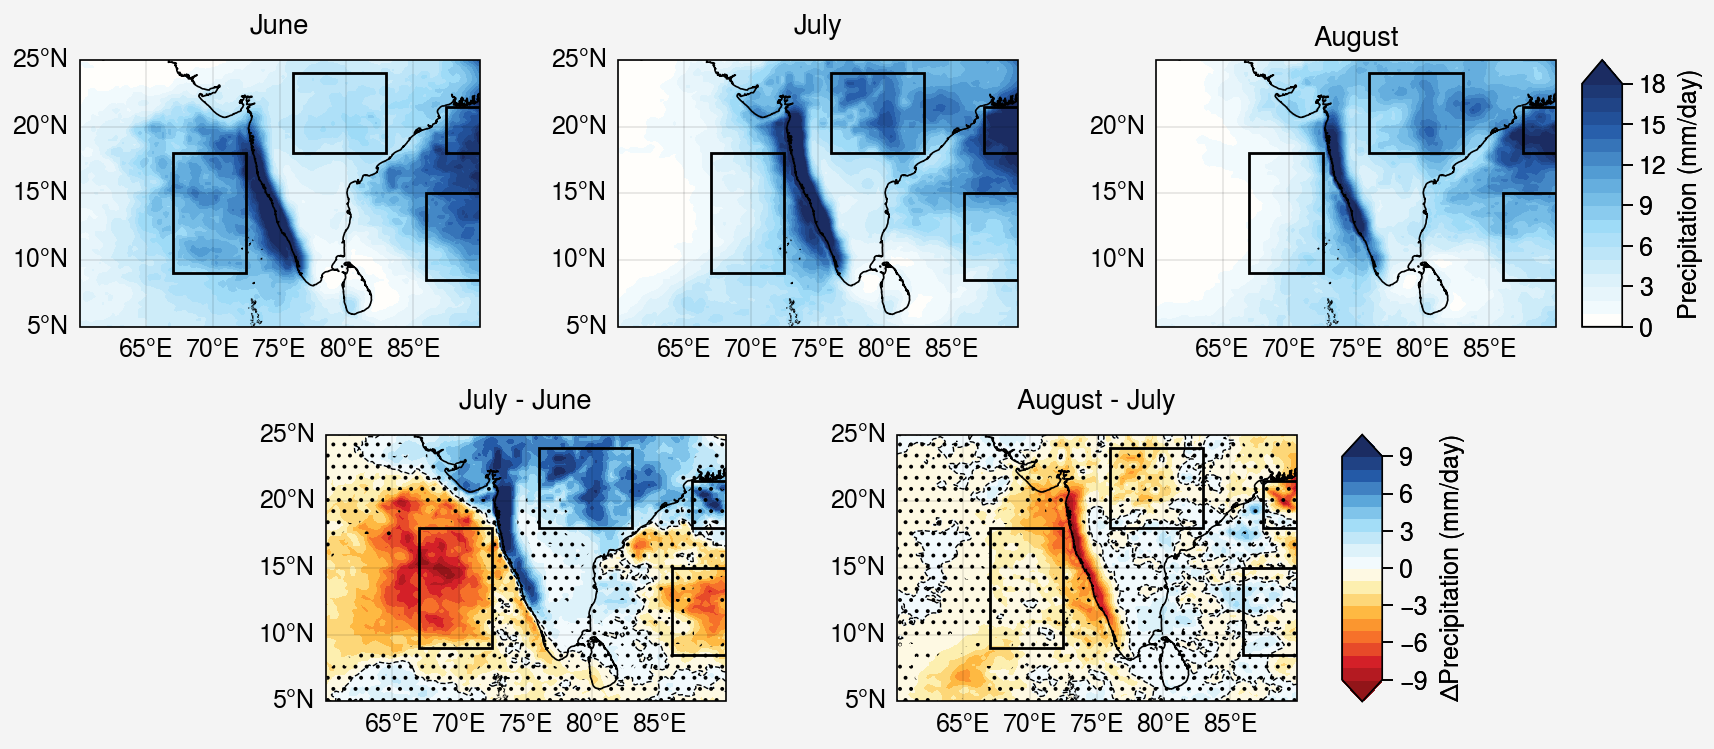

In [53]:
pr = data.pr.groupby('time.month').mean(dim='time')
jjprdiff = pr.sel(month=7)-pr.sel(month=6)
japrdiff = pr.sel(month=8)-pr.sel(month=7)

grid = [[1,1,2,2,3,3],
        [0,4,4,5,5,0]]

fig = pplt.figure(refwidth=2)
axs = fig.subplots(grid,proj='cyl')
axs.format(coast=True,latlim=LATRANGE,latlines=5,latlabels=True,lonlim=LONRANGE,lonlines=5,lonlabels=True)
axs[0].format(title='June')
axs[1].format(title='July')
axs[2].format(title='August')
axs[3].format(title='July - June')
axs[4].format(title='August - July')

for region in REGIONS.values():
    for ax in axs:
        ax.add_patch(make_patch(region['lonmin'],region['lonmax'],region['latmin'],region['latmax']))

m = axs[0].contourf(pr.sel(month=6),**prkwargs)
axs[1].contourf(pr.sel(month=7),**prkwargs)
axs[2].contourf(pr.sel(month=8),**prkwargs)
axs[2].colorbar(m,loc='r',ticks=3,label='Precipitation (mm/day)')

m = axs[3].contourf(jjprdiff,**diffkwargs)
axs[3].contour(jjprdiff,**divkwargs)
axs[3].contourf(~jjsignificant,levels=[0.5,1],hatches=['...',None],colors='none')
axs[4].contourf(japrdiff,**diffkwargs)
axs[4].contour(japrdiff,**divkwargs)
axs[4].contourf(~jasignificant,levels=[0.5,1],hatches=['...',None],colors='none')
axs[4].colorbar(m,loc='r',ticks=3,label='$\Delta$Precipitation (mm/day)')